# Coffee
This workbook contains a simulation of a shop.
The goal is to extend the simulation, from its inital state as a cake shop, to a proper coffee and cake shop, by adding new classes.

In [10]:
%matplotlib inline
from collections import defaultdict, deque

import numpy

import matplotlib.pyplot as plt

## Helper Functions

These are used to provide a distribution of customers attending the shop

In [11]:
def consume_area(x, y, start, area):
    """Given a cyclic peicewise linear graph, such that the first and last points are tied,
    this moves forward from the start position until it has consumed the given area.
    Returns how far it had to move, noting that it will keep counting up as it wraps around."""
    start = start % x[-1]
    
    # Determine starting segment and t value...
    segment = numpy.searchsorted(x, start)
    t = (start - x[segment]) / (x[segment+1] - x[segment])
    
    # Keep moving forward a segment at a time until the end point is in the current segment...
    travel = 0.0
    while True:
        delta = x[segment+1] - start
        segment_area = 0.5 * ((1-t) * y[segment] + (t+1) * y[segment+1]) * delta
        if segment_area > area:
            break
        
        area -= segment_area
        travel += delta
        segment = (segment + 1) % (x.shape[0] - 1)
        
        start = x[segment]
        t = 0.0
    
    # Now determine the exact point to stop in the current segment...
    # (Using the Citardauq variant of the quadratic equation for numerical stability)
    height = (1-t) * y[segment] + t * y[segment+1]
    grad = (y[segment+1] - y[segment]) / (x[segment+1] - x[segment])
    
    srt = numpy.sqrt(4*height*height + 8*grad*area)
    tra = 4 * area / (2 * height + srt)

    return travel + tra


## Task Interface
The below can be considered to be an _interface_, a specification for an object kind that we need to comply with for multiple other objects. It is not actually necesary - the below code could be deleted, none of the tasks would inherit from a base class, and everything would work just fine due to _duck typing_. However, from an understandability point of view this is strongly prefered, as it makes it clear how everything is to work. It also ensures that the correct errors are thrown if a Task is not implimented completely.

In [12]:
class Task:
    """The simulation is based on performing tasks - the Timeline object has multiple
    tasks enqueued in it, and completes them in order as the required resources
    become avaliable."""
    
    def time(self):
        """Returns how many seconds the task will take."""
        raise NotImplementedError

    def depends(self):
        """yields all of the items that have to be free for the task to run, so
        they can be iterated. Whilst any item is in use no other task that
        depends on the same item can run."""
        raise NotImplementedError

    def __call__(self, timeline):
        """When a task finishes this code is called. It will normally update the
        simulation with the results of performing the task and enqueue any further
        Task's required."""
        raise NotImplementedError


## Timeline
The timeline is the most complex peice of code in the simulation, as it manages everything, in particular time. It actually has multiple independent capabilities:
 * It manages tasks, which is to it say queues them up and makes sure that they are only run when all dependencies for each task are avaliable (as in not being used for another task).
 * It handles queues (of customers), pairing off the item from the front of the queue with the object that has offered to process the queue item.
 * It manages time, specifically looping through it and starting/ending tasks at the required moments, interleaving their execution as required. It is not real time, and will jump through as fast as possible. For instance when the shop is closed and nothing is hapenning is will skip through this time period in a single step, but could take hundreds of steps in a single minute during lunchtime when there is a lot of activity.
 * Because it is a centralised object that every part of the simulation has access to is also includes an event recording system, so statistics can be recorded and visualised after a simulation has run.

In [13]:
class Timeline:
    """This runs a simulation - Task objects are registered with it and called
    (Task-s are functors) when they are complete, as in enough time has passed.
    Note that time is not a real delay, as the code runs as fast as it can and
    can simulate an entire day in seconds. The point it to know how quickly
    events occur so statistics, such as customers per hour, can be calculated."""
    def __init__(self):
        self.running = [] # Tasks that are currently running, as pairs of [time remaining, Task], sorted.
        self.waiting = [] # Queue of tasks, in order provided, that are yet to start running.
        
        # For simulating customers forming a queue. The customers are added to the source list.
        # The sink list contains the methods of cashiers that are watching the queue.
        # During the event loop when both lists contain itesm they are removed, and the
        # watcher method is called with (timeline, customer).
        # Can also be used for any other queuing situation.
        self.queue = defaultdict(lambda: {'sink' : deque(), 'source' : deque()})
        
        # Time in simulation...
        self.now = 0.0
    
    
    def time(self):
        return self.now
    
    
    def __start(self):
        """Internal method (note the __) that moves all Task-s from the queue to
        running that it can. It uses a reservation system, so a resource (person)
        will wait to complete an earlier task on the queue."""
        
        # This set is used during the below to determine who is reserved to help a task.
        # It contains the id() of each dependency that is in use.
        # (id returns an integer unique to an object).
        reservation = set()
        
        # Mark resources used by currently running tasks...
        for _, task in self.running:
            for dep in task.depends():
                reservation.add(id(dep))
        
        # Loop queue and move over any tasks that can be started...
        # (have to rebuild the queue - deletion whilst looping is a bad idea)
        old_waiting = self.waiting
        self.waiting = list()
        
        for task in old_waiting:
            # Find out if it can be run...
            can_run = True
            for dep in task.depends():
                if id(dep) in reservation:
                    can_run = False
                    break
            
            if can_run:
                for dep in task.depends():
                    reservation.add(id(dep))
                self.running.append([task.time(), task])
            else:
                self.waiting.append(task)

        # Sort the list of running tasks by time...
        self.running.sort()
    
    
    def simulate(self, time = 60 * 60):
        """Simulates the timeline for the given length of time, which defaults to an hour.
        Returns a dictionary of all events that occured during that time. The keys are the
        event names, you then have a list of every event. Events are either just a time (in
        seconds), or a tuple with time as the first entry, everything extra afterwards."""
        
        # Make sure that there is something running...
        self.__start()
        
        # Reset the event log...
        self.events = defaultdict(list)
        self.now = 0.0
        
        
        # Loop and process until we run out tasks (loop condition) or time (test in loop)...
        while len(self.running)!=0:
            
            
            # Move forwards in time, until we run out of time to move forward into...
            step = self.running[0][0]
            
     
            if step > time:
                for task in self.running:
                    task[0] -= time
                self.now = 0.0
                return self.events
            
            time -= step
            self.now += step
            for task in self.running:
                task[0] -= step
            
            # Finish all tasks that have run out of time...
            while (len(self.running) > 0) and (self.running[0][0] < 0.1): # 0.1 is close enough to simultaneous!
                task = self.running.pop(0) # pop(0) deletes and returns the first item in a list.
                task[1](self)
            
            # For all queues pair up source and sinks objects and run the callback code to process them...
            qlc = list(self.queue.values()) # Take a copy - could change mid-iteration!
            for q in qlc:
                while len(q['source'])>0 and len(q['sink'])>0:
                    obj = q['source'].popleft()
                    callback = q['sink'].popleft()
                    callback(self, obj)
            
            # Use __start to get more tasks running (may have been added during above loop)...
            self.__start()

            
    def enqueue(self, task):
        """Enqueues the given task to be run."""
        self.waiting.append(task)
    
    
    def drop(self, dependency):
        """Removes all tasks, running or queued, that depend on the given object."""
        self.running = [pair for pair in self.running if dependency not in pair[1].depends()]
        self.waiting = [task for task in self.waiting if dependency not in task.depends()]
    
    
    def join_queue(self, name, obj):
        """Adds the given object to the named queue, where other objects can pop it off and interact with it."""
        self.queue[name]['source'].append(obj)
    
    
    def watch_queue(self, name, callback):
        """Given a callback (a function or method) it is called when an object becomes avaliable
        on the named queue (via a call to join_queue). It is called with the parameters (timeline, object)."""
        self.queue[name]['sink'].append(callback)
    
    
    def record(self, event, *extra):
        """Records an event has occured, such that statistics can be calculated later.
        event is the name of the event, and you can optionally provide further information
        to be returned."""
        if len(extra)==0:
            self.events[event].append(self.now)
        else:
            self.events[event].append((self.now,) + extra)


## Menu
A shop that sells food needs a menu - for now just cake.

Each cake needs to come with a price, how it is prepared (for now just `'grab'`, in the sense the cashier picks it up and hands it to customer) and extra meta data. For `'grab'` this is a tuple of two values - the minimum and maximum time it takes to grab the item and hand it to the customer.

In [14]:
# A menu - for this part of the worksheet just items the cashier can grab and hand to the customer immediately...
# 'item' : (cost, 'grab', (minimum time to grab, maximum time to grab))...
menu = {}

menu['Banoffee Pie'] = (3.80, 'grab', (20.0, 30.0))
menu['Butterfly Cake'] = (1.00, 'grab', (5.0, 15.0))
menu['Caterpillar Cake'] = (20.00, 'grab', (60.0, 90.0))
menu['Lava Cake'] = (4.20, 'grab', (80.0, 120.0))
menu['Tiramisu'] = (3.50, 'grab', (15.0, 25.0))


## Customer and Cashier Tasks
These are the tasks needed for a basic cake shop simulation, just a customer choosing what to buy and a cashier serving the customer by handing them their cake. Note the use of random number generation in both to generate some vaguely plausible variability in how long these tasks take.

In [15]:
## purchsing item and time
class ChoosePurchase(Task):
    """A task to describe a customer standing around and staring at the menu, choosing what to purchase."""
    def __init__(self, customer):
        self.customer = customer
        
        # Decide how quick they are going to be...
        if numpy.random.rand() < 0.2:
            self.delay = 2.0 # They are a regular and already know.
        
        else:
            self.delay = len(menu) + numpy.random.exponential(30.0)


    def time(self):
        return self.delay

##specific to that customer
    def depends(self):
        yield self.customer


    def __call__(self, timeline):
        # Select how many items to buy...
        buy = 1 + numpy.random.poisson(0.5)
        
        # Draw them randomly from the menu, weighted by their inverse price...
        # (so cheap items are bought more often)...
       
        options = list(menu.keys())
        prob = numpy.array([1.0 / menu[option][0] for option in options])
        prob /= prob.sum()
        
         ## buying the product
        buy = numpy.random.choice(options, p=prob, size=buy)
        self.customer.go_buy(timeline, list(buy))


##cashier serving the customer 
class ServeCustomer(Task):
    def __init__(self, timeline, cashier, customer):
        self.cashier = cashier
        self.customer = customer
        
        # How long is it going to take...
        #req cosists all of items the customer has
        req = customer.to_buy()
        ## 3 seconds per item for the customer to tell the cashier...
        self.delay = len(req) * 3.0
        
        ## Payment time assumed to be a uniform draw from a suitable range...
        self.delay += numpy.random.uniform(1.0, 40.0)
        
        ## Time for the cashier to grab everything rqeuested...
        self.grabbing = []
        for r in req:
            targ = menu[r]
            if targ[1]=='grab':
                self.delay += numpy.random.uniform(targ[2][0], targ[2][1])
                self.grabbing.append(r)
        #adding delay per item
                timeline.record(self, 'purchase food',r)
            if targ[1]=='barista':
                timeline.join_queue('brew',(customer, r))
                

    def time(self):
        return self.delay


    def depends(self):
        yield self.cashier
        yield self.customer


    def __call__(self, timeline):
        #cashier back to watch till again
        self.cashier.after_customer(timeline)

        for name in self.grabbing:
            #customer revceives their item
            self.customer.receive_item(timeline, name)
            timeline.record('purchase food', name)


## Customers
The customer object is reasonably straight forward, because all of the clever stuff is in the code of the tasks they are involved in. Every method here is called from a task to either set the next action of the customer going or get some information from the customer.

In [16]:
class Customer:
    """A customer walks into the shop, chooses what to buy from the menu, and then joins
    the queue for the cashier. When they get to the front they ask and pay for what they
    want, and the cashier gets it for them. Then they leave."""
    def __init__(self, timeline):
        # Record that a customer arrived...
        timeline.record('arrive')
        self.enter = timeline.time()
        
        # First thing a customer needs to do is decide what to purchase...
        task = ChoosePurchase(self)
        
        #do the task
        timeline.enqueue(task)

    ## going to buy the iteams
    def go_buy(self, timeline, buy):
        """This is called by the ChoosePurchase event to indicate it's time to go buy something.
        It records what to buy, and joins the queue."""
        self.buy = buy
    ## goes to cashier
        timeline.join_queue('tills', self)
    
    
    def to_buy(self):
        """Returns what the customer wants to buy."""
        return self.buy[:] # [:] makes a copy of the list.
    
    
    def receive_item(self, timeline, name):
        """Marks off the item from the customers list of things to buy"""
        # Find the item in the list...
        i = self.buy.index(name)
        
        #if customer receive item it is deleted from list
        # Delete...
        del self.buy[i]
        
        # If they have everything they want leave...
        if len(self.buy)==0:
            self.leave(timeline)
            
        
    def leave(self, timeline):
        """Called when the customer is leaving. Main purpose is to record how long
        they spent in the shop."""
        # Record that a customer departed, including how long they were in the shop for...
        timeline.record('leave', timeline.time() - self.enter)
        
        # Do nothing - if we don't add the customer to a queue or task they will just be deleted,
        # as with nothing in Python referencing them the garbage collector will get them.


        

## Customer Generation
As the simulation is driven entirely by the actions of customers we need some code to generate them. The below task does something sneaky - it waits until the next customer arrives, adds that customer, then generates a new copy of the exact same task which then waits until the following customer arrives, and so on. It is the event equivalent of an infinite loop, and will create customers forever.

To give the customers realistic arrival times a Poisson process is used. Mathematically this is quite fiddly, but the idea is simple: We assume all customers arrive independently, and that the average number of customers arriving during a time period can be represented by the area under a density graph. Given these assumptions their is only one solution.

The density graph was generated using the footfall data set for Micklegate in York, on Monday 2016-10-10 (Note that York is a northern city with Viking heritage - 'gate' in this context means 'road'). It was scaled by 0.05 on the assumption that 5% of people going past a coffee shop go in, and zeroed outside of 7am - 9pm to simulate opening hours. The end result is not unreasonable - you get a lunch surge, and the total customer count matches with that of a smaller independent coffee shop. There is also a slight surge around 3-4pm caused by a nearby school.

Footfall data (Open government license) obtained from:
https://data.gov.uk/dataset/footfall/resource/3db574a2-05ed-4ea4-83a4-5c0e59345c30

In [17]:
class GenerateCustomer(Task):
    """This impliments a variable density Poisson process to simulate customers arriving,
    by calculating how long to wait until the next customer arrives, at which point it
    will generate that customer, and add another instance of this class to the task queue,
    which will wait a sutiable amount of time before doing it all over again. This means
    there is a never ending supply of customers arriving."""
    
    # This is the density of customers arriving in the day, as a peicewise
    # linear graph over the day, as a matrix where [:,0] is the time, [:,1] the height.
    # The area of the graph is the expected number of customers each day.
    density = numpy.array([[0.0,0.0], [5.99,0.0], [6.01,1.2], [6.5,1.2],
                           [7.5,3.4], [8.5,14.0], [9.5,14.8], [10.5,17.3],
                           [11.5,22.2], [12.5,34.1], [13.5,21.9], [14.5,21.4],
                           [15.5,27.5], [16.5,27.3], [17.5,21.9], [18.5,8.6],
                           [19.5,6.2], [20.5,4.0], [20.99,4.0], [21.01,0.0], [24.0,0.0]])
    
    def __init__(self, now):
        """now is the time when the task is added to the queue, so it knows where in the
        day to query the density for. Unit is hour of the day, [0, 24), as that is more
        conveniant here."""
        # Draw how much area under the graph to consume...
        consume = numpy.random.standard_exponential()
        
        # Work out the step forward in time required to consume that much area under the graph...
        passed = consume_area(self.density[:,0], self.density[:,1], now, consume)
        
        # Record the step forward as how long the event should last, and the
        # new time to hand to the next instacne of this event...
        self.delay = passed
        self.then = (now + self.delay) % 24.0
    
    
    def time(self):
        return self.delay * 60.0 * 60.0 # Hours to seconds
    
    
    def depends(self):
        return []
    
    
    def __call__(self, timeline):
        # Create new customer - don't need to record the object as events/queues
        # will ensure it persists until it is no longer relevant...
        Customer(timeline)
        
        # Create and enque the next GenerateCustomer task...
        timeline.enqueue(GenerateCustomer(self.then))


### Testing Customer Generation
The below code demonstrates the simplest simulation possible, where customers enter the shop, but, as there are no cashiers, queue up without ever being served. A histogram is plotted to show how many arrived during each hour of the day the simulation is run for.

Note that the use of random number generation means you get a different result every time you run this code - you may want to run it several times to see how the graph changes.

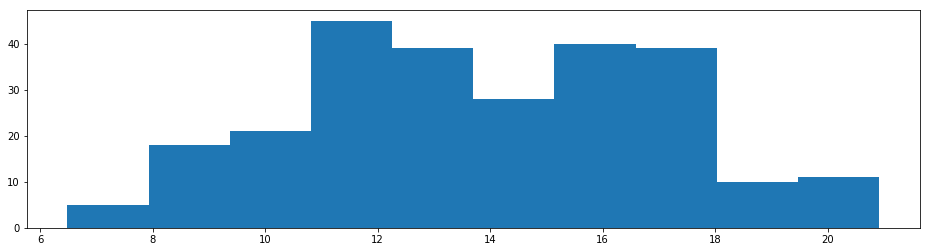

Total customers 256


In [18]:
# Create a timeline and initialise customer generation...
timeline = Timeline()
timeline.enqueue(GenerateCustomer(0.0)) # 0 here is effectively the starting time of the simulation - midnight.


# Simulate for 24 hours...
events = timeline.simulate(24.0 * 60.0 * 60.0)


# Plot the customers arriving at the shop...
plt.figure(figsize=(16,4))
plt.hist(numpy.array(events['arrive']) / (60*60)) # Division to convert to hours from seconds
plt.show()

print('Total customers', len(events['arrive']))

## Cashier
The Cashiers job is to stand there, watch the queue of customers and serve each in turn.

This introduces the idea of a callback - it passes one of it's methods into the `watch_queue()` method. This is then stored, it is just a variable like any other, and then ultimately called as function when there is a customer to serve.

In [19]:
class Cashier:
    """They simple stand there and serve each customer in turn."""
    def __init__(self, timeline):
        timeline.watch_queue('tills', self.handle_customer)
    
    
    def handle_customer(self, timeline, customer):
        task = ServeCustomer(timeline, self, customer)
        timeline.enqueue(task)
    
    
    def after_customer(self, timeline):
        timeline.watch_queue('tills', self.handle_customer)


## Just a Cake Shop

The below simulation prints a scatter plot of waiting time for each customer during the day for a shop with one cashier and a menu of cake. Customers queue up and select cake, queue, buy cake, and then leave.

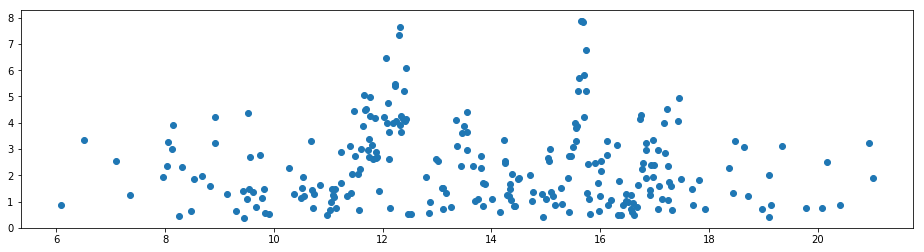

In [21]:
# Create a timeline and initialise customer generation...
timeline = Timeline()
timeline.enqueue(GenerateCustomer(0.0)) # 0 here is effectively the starting time of the simulation - midnight.

# Add a Cashier -
# timeline object will prevent it from being automatically deleted (garbage collected)...
Cashier(timeline)
# Simulate for 24 hours...
events = timeline.simulate(24.0 * 60.0 * 60.0)


# Print out a scatter plot of how long customers were in the shop for against time of day...
data = numpy.array(events['leave'])
data[:,0] /= 60 * 60 # Time into hours.
data[:,1] /= 60 # Time in shop as minutes.

plt.figure(figsize=(16,4))
plt.scatter(data[:,0], data[:,1])
plt.show()

## 1. Two Cashiers

We will now run a simulation with two cashiers and compare how the waiting times change relative to one cashier

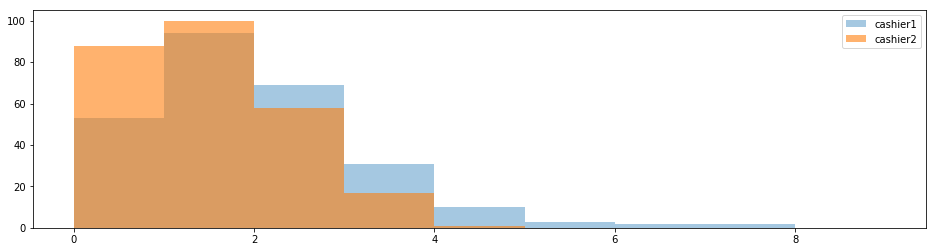

In [23]:
# Create a timeline and initialise customer generation...
timeline = Timeline()
timeline2 = Timeline()
timeline.enqueue(GenerateCustomer(0.0)) # 0 here is effectively the starting time of the simulation - midnight.
timeline2.enqueue(GenerateCustomer(0.0)) # 0 here is effectively the starting time of the simulation - midnight.

# Add a Cashier - note how we don't need to keep the variable, as the
# timeline object will prevent it from being automatically deleted (garbage collected)...
Cashier(timeline)

Cashier(timeline2)
Cashier(timeline2)
# Simulate for 24 hours...
events = timeline.simulate(24.0 * 60.0 * 60.0)
events2 = timeline2.simulate(24.0 * 60.0 * 60.0)
# Print out a scatter plot of how long customers were in the shop for against time of day...
data = numpy.array(events['leave'])
data[:,0] /= 60 * 60 # Time into hours.
data[:,1] /= 60 # Time in shop as minutes.

data2 = numpy.array(events2['leave'])
data2[:,0] /= 60 * 60 # Time into hours.
data2[:,1] /= 60 # Time in shop as minutes.

plt.figure(figsize=(16,4))
plt.hist(data[:,1],bins=[0,1,2,3,4,5,6,7,8,9],label = ['cashier1'],alpha = 0.4)
plt.hist(data2[:,1],bins=[0,1,2,3,4,5,6,7,8,9],label = ['cashier2'], alpha = 0.6)
plt.legend(loc='upper right')
plt.show()


## 2. Purchase Statistics

Next we wana get the statisics of each item purchased in the simulation

In [28]:
import pandas as pd

events = timeline.simulate(24.0 * 60.0 * 60.0)

eventsArray = numpy.array(events['purchase food'])
eventsUnique = numpy.unique(eventsArray[:,1])

foodOutDict = {}
#creating dictionary of items sold

i = 0
for food in eventsUnique:
    foodCount = 0
    for item in eventsArray[:,1]:
        if food == item:
            foodCount+=1
    foodOutDict[food]= foodCount

#calculating takings
outputValue = 0

for keys, freq in foodOutDict.items():
    for menuKeys, menuPrice in menu.items():
        if keys == menuKeys:
            outputValue += menuPrice[0] * freq
print('takings = £',outputValue)


takings = £ 1111.6


## 3. Coffee Shop
We now modify the system so that the shop serves coffee. This requires the following tasks:
 * Modify the ServeCustomer(Task) (above) to respond to 'barista' menu item requests by adding them to a 'brew' queue in the Timeline
 * Adding a Brew(Task) class
 * Adding a Barista class as a staff member that watches the brew queue and makes each coffee as the requests arrive.
 

In [30]:
#Extending the menu - same meaning as for 'grab' except it's how long it takes a barista to 'brew' the coffee...
menu['Espresso'] = (2.00, 'barista', (10.0, 20.0))
menu['Flat White'] = (2.80, 'barista', (40.0, 90.0))
menu['Americano'] = (2.40, 'barista', (20.0, 30.0))
menu['Latte'] = (3.20, 'barista', (60.0, 120.0))


class Barrista:
    """They simple stand there and serve each customer in turn."""
    def __init__(self, timeline):
        timeline.watch_queue('brew', self.handle_customer)
    
    
    def handle_customer(self, timeline, custTuple):
        task = Brew(timeline, self, custTuple[0],custTuple[1])
        timeline.enqueue(task)
    
    
    def after_customer(self, timeline):
        timeline.watch_queue('brew', self.handle_customer)
        
        
class Brew(Task):

    def __init__(self, timeline,  barrista, customer, coffee):
        self.barrista = barrista
        self.customer = customer
        self.coffee = coffee
        
        # How long is it going to take...
        # list of all coffees need to make
        self.coffeeList = []
        ## Payment time assumed to be a uniform draw from a suitable range...
        self.delay = numpy.random.uniform(menu[coffee][2][0],menu[coffee][2][1])
        self.coffeeList.append(coffee)

    def time(self):
        return self.delay


    def depends(self):
        yield self.barrista
        yield self.customer

    def __call__(self, timeline):
        #cashier back to watch till again
        self.barrista.after_customer(timeline)

        for name in self.coffeeList:
            #customer revceives their item
            self.customer.receive_item(timeline, name)
            timeline.record('purchase coffee', name)


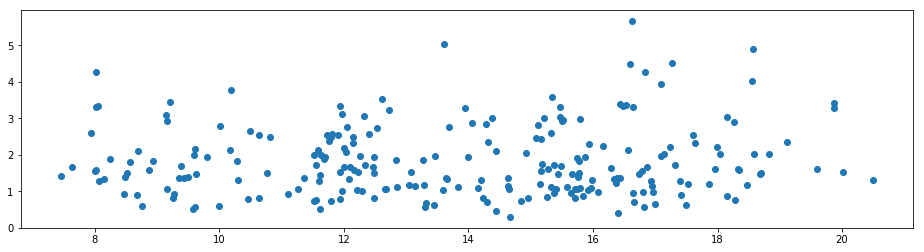

In [31]:
# Create a timeline and initialise customer generation...
timeline2 = Timeline()
timeline2.enqueue(GenerateCustomer(0.0)) # 0 here is effectively the starting time of the simulation - midnight.

# Add a Cashier - note how we don't need to keep the variable, as the
# timeline object will prevent it from being automatically deleted (garbage collected)...
Cashier(timeline2)
Cashier(timeline2)
Barrista(timeline2)
# Simulate for 24 hours...
events = timeline2.simulate(24.0 * 60.0 * 60.0)


# Print out a scatter plot of how long customers were in the shop for against time of day...
data = numpy.array(events['leave'])
data[:,0] /= 60 * 60 # Time into hours.
data[:,1] /= 60 # Time in shop as minutes.

plt.figure(figsize=(16,4))
plt.scatter(data[:,0], data[:,1])
plt.show()

## 4. Everyone wants Coffee

The current purchasing pattern of a customer expressed in ChoosePurchase(Task) is not very realistic. We will now incorporate some rules to the simulation

 * Everyone who enters a coffee shop has a 70% chance of buying for themselves, a 30% chance of buying for a group of 2-4 people (including the customer). All group sizes (2, 3 or 4) have equal probability within their 30% bracket.
 * Coffee is always bought for each person.
 * There is a 50:50 chance of cake being bought; if it is then everyone in the group gets one.
 * The probability of each coffee is proporitional to it's price - people prefer expensive coffee.
 * The probability of cake is inversely proportional to it's price - people prefer cheap cake.

In [34]:
class ChoosePurchase(Task):
    """A task to describe a customer standing around and staring at the menu, choosing what to purchase."""
    def __init__(self, customer):
        self.customer = customer
        
        # Decide how quick they are going to be...
        if numpy.random.rand() < 0.2:
            self.delay = 2.0 # They are a regular and already know.
        
        else:
            self.delay = len(menu) + numpy.random.exponential(30.0)


    def time(self):
        return self.delay


    def depends(self):
        yield self.customer


    def __call__(self, timeline):
        
        #selcting number of people
        groupSize =numpy.random.choice([1,2,3,4],p=[0.7,0.1,0.1,0.1])
        
        #selct how many coffees to buy
        numCoffees = groupSize
        
        #select amount of cake
        numCakes = numpy.random.choice([groupSize,0],p=[0.5,0.5])
        
        # Select how many items to buy...
        buy = 1 + numpy.random.poisson(0.5)
        
        
        # Draw them randomly from the menu, weighted by their inverse price...       
        cakeOptions = list(menu.keys())[:5]
        probCake = numpy.array([1.0 / menu[option][0] for option in cakeOptions])
        probCake /= probCake.sum()

        
        coffeeOptions = list(menu.keys())[5:9]
        probCoffee = numpy.array([menu[option][0] for option in coffeeOptions])
        probCoffee /= probCoffee.sum()
        
         ## buying the product
        buycake = list(numpy.random.choice(cakeOptions, p=probCake, size=numCakes))
        buycoffee = list(numpy.random.choice(coffeeOptions, p=probCoffee, size=numCoffees))
        
        buy = buycake + buycoffee
        self.customer.go_buy(timeline, list(buy))


 Now we will generate a scatter plot of the time of day vs waiting time and record the sales quantities and takings.

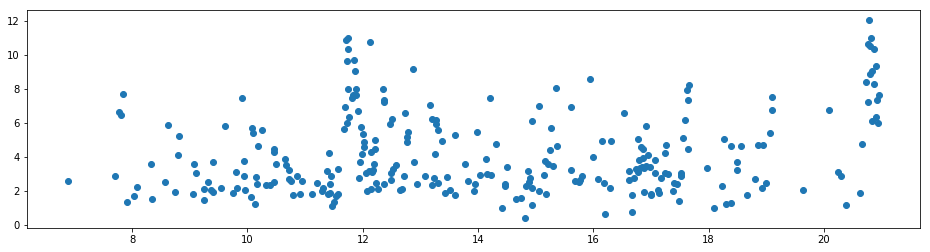

{'Tiramisu': 21, 'Lava Cake': 22, 'Butterfly Cake': 93, 'Banoffee Pie': 21, 'Caterpillar Cake': 315}
{'Latte': 42, 'Espresso': 40, 'Americano': 32, 'Flat White': 36}
Takings = £ 7030.7


In [40]:
# Create a timeline and initialise customer generation...
timeline = Timeline()
timeline.enqueue(GenerateCustomer(0.0)) # 0 here is effectively the starting time of the simulation - midnight.

# Add a Cashier
Cashier(timeline)
Cashier(timeline)
Barrista(timeline)
# Simulate for 24 hours...
events = timeline.simulate(24.0 * 60.0 * 60.0)


# Print out a scatter plot of how long customers were in the shop for against time of day...
data = numpy.array(events['leave'])
data[:,0] /= 60 * 60 # Time into hours.
data[:,1] /= 60 # Time in shop as minutes.

plt.figure(figsize=(16,4))
plt.scatter(data[:,0], data[:,1])
plt.show()

eventsArray = numpy.array(events['purchase food'])
eventsUnique = numpy.unique(eventsArray[:,1])

eventsArrayCoffee = numpy.array(events['purchase coffee'])
eventsCoffeeUnique = numpy.array(eventsArrayCoffee[:,1])

foodOutDict = {}
coffeeOutDict = {}

#creating dictionary of items sold
i = 0
for food in eventsUnique:
    foodCount = 0
    for item in eventsArray[:,1]:
        if food == item:
            foodCount+=1
    foodOutDict[food]= foodCount

#creating dictionary of coffee

i = 0
for coffee in eventsCoffeeUnique:
    coffeeCount = 0
    for item in eventsArrayCoffee[:,1]:
        if coffee == item:
            coffeeCount+=1
    coffeeOutDict[coffee]= coffeeCount
print (foodOutDict)
print (coffeeOutDict)

#calculating takings
outputValue = 0

for keys, freq in foodOutDict.items():
    for menuKeys, menuPrice in menu.items():
        if keys == menuKeys:
            outputValue += menuPrice[0] * freq

for keys, freq in coffeeOutDict.items():
    for menuKeys, menuPrice in menu.items():
        if keys == menuKeys:
            outputValue += menuPrice[0] * freq
print('Takings = £',numpy.round(outputValue,2))